Para el desarrollo del software se ha optado por el uso de la distribución Anaconda, debido a su robustez en la gestión de entornos virtuales y paquetes científicos. Como entorno de desarrollo integrado (IDE) se utiliza Visual Studio Code, permitiendo una integración fluida con los cuadernos de Jupyter y el control de versiones mediante Git.
Fuente: Anaconda Distribution Documentation


In [1]:
import requests
import os

# 1. Definimos la URL de una fuente fiable que distribuye datos de la NASA/NORAD
# Celestrak es el estándar académico para obtener TLEs actualizados.
URL_ISS = "https://celestrak.org/NORAD/elements/gp.php?GROUP=stations&FORMAT=tle"

# 2. Creamos la carpeta de datos si no existe (siguiendo tu estructura de repo)
ruta_datos = "../data/"
if not os.path.exists(ruta_datos):
    os.makedirs(ruta_datos)

# 3. Descargamos la información
response = requests.get(URL_ISS)

if response.status_code == 200:
    with open(f"{ruta_datos}iss_tle.txt", "wb") as f:
        f.write(response.content)
    print("¡Éxito! El archivo iss_tle.txt ha sido guardado en la carpeta /data")
else:
    print(f"Error al conectar con el servidor: {response.status_code}")

¡Éxito! El archivo iss_tle.txt ha sido guardado en la carpeta /data


Se ha implementado un módulo de adquisición de datos automatizado que consulta la base de datos de CelesTrak. Esta fuente es fundamental ya que actúa como repositorio de los datos generados por el NORAD (North American Aerospace Defense Command) y la NASA. El formato obtenido es el TLE (Two-Line Element), el cual es el estándar internacional para representar la posición y velocidad de objetos en órbita terrestre.
Fuente: CelesTrak - FAQ and Data Formats

In [2]:
# Abrimos el archivo que acabamos de descargar para leer las primeras líneas
with open("../data/iss_tle.txt", "r") as f:
    contenido = f.readlines()

# Mostramos las primeras 3 líneas (que corresponden a la ISS)
for linea in contenido[:3]:
    print(linea.strip())

ISS (ZARYA)
1 25544U 98067A   26053.21713984  .00012819  00000+0  24697-3 0  9992
2 25544  51.6319 148.8375 0008515 121.3250 238.8573 15.48201707553932


In [4]:
from skyfield.api import load, EarthSatellite

# 1. Cargamos la escala de tiempo astronómica
ts = load.timescale()

# 2. Leemos las líneas que imprimiste antes (asegúrate de que coincidan los índices)
linea1 = "1 25544U 98067A   26053.21713984  .00012819  00000+0  24697-3 0  99922"
linea2 = "2 25544  51.6319 148.8375 0008515 121.3250 238.8573 15.48201707553932"

# 3. Creamos el objeto satélite
satelite = EarthSatellite(linea1, linea2, "ISS (ZARYA)", ts)

# 4. Calculamos la posición en este preciso instante (ahora mismo)
tiempo_actual = ts.now()
posicion = satelite.at(tiempo_actual)

# 5. Proyectamos la posición sobre la superficie de la Tierra (subpunto)
subpunto = posicion.subpoint()

print(f"Momento del cálculo: {tiempo_actual.utc_strftime('%Y-%m-%d %H:%M:%S')} UTC")
print(f"Latitud actual: {subpunto.latitude.degrees:.4f}")
print(f"Longitud actual: {subpunto.longitude.degrees:.4f}")
print(f"Altitud: {subpunto.elevation.km:.2f} km")

Momento del cálculo: 2026-02-22 16:48:47 UTC
Latitud actual: 2.8124
Longitud actual: -80.5712
Altitud: 418.90 km


Para el entrenamiento del modelo predictivo, se ha generado un conjunto de datos sintético basado en la propagación histórica del TLE actual. Se ha utilizado la librería Pandas para la estructuración de los datos en formato de series temporales.
Fuente: McKinney, W. (2010). Data Structures for Statistical Computing in Python

In [5]:
import pandas as pd
from datetime import datetime, timedelta

# 1. Creamos una lista para ir guardando los datos calculados
datos_trayectoria = []

# 2. Obtenemos el tiempo actual
ahora = datetime.utcnow()

print("Calculando posiciones...")

# 3. Bucle para calcular la posición minuto a minuto (60 puntos)
for i in range(60):
    # Calculamos el momento exacto (restamos i minutos al momento actual)
    momento = ahora - timedelta(minutes=i)
    
    # Convertimos el tiempo al formato que entiende Skyfield
    t = ts.utc(momento.year, momento.month, momento.day, 
               momento.hour, momento.minute, momento.second)
    
    # Calculamos la posición en ese minuto
    pos = satelite.at(t)
    sub = pos.subpoint()
    
    # Guardamos la fila de datos en nuestra lista
    datos_trayectoria.append({
        "timestamp_utc": momento,
        "latitud": sub.latitude.degrees,
        "longitud": sub.longitude.degrees,
        "altitud_km": sub.elevation.km
    })

# 4. Convertimos la lista en una tabla (DataFrame)
df_iss = pd.DataFrame(datos_trayectoria)

# 5. Guardamos la tabla en un archivo CSV en tu carpeta /data
df_iss.to_csv("../data/historial_posicion_iss.csv", index=False)

print("¡Dataset guardado con éxito en la carpeta /data!")
print(df_iss.head()) # Esto te muestra las primeras 5 filas de tu nueva tabla

Calculando posiciones...
¡Dataset guardado con éxito en la carpeta /data!
               timestamp_utc    latitud   longitud  altitud_km
0 2026-02-22 17:04:26.305883 -41.277663 -38.612835  437.804484
1 2026-02-22 17:03:26.305883 -39.012073 -42.447899  436.508795
2 2026-02-22 17:02:26.305883 -36.611063 -46.024497  435.153847
3 2026-02-22 17:01:26.305883 -34.093122 -49.366922  433.755768
4 2026-02-22 17:00:26.305883 -31.474567 -52.500015  432.331129


C:\Users\richa\AppData\Local\Temp\ipykernel_23928\2126665536.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ahora = datetime.utcnow()


Para generar el conjunto de datos de entrenamiento, se ha procedido a realizar una propagación histórica de la órbita utilizando el modelo SGP4. Los datos resultantes se han estructurado mediante la librería Pandas, permitiendo su almacenamiento en formato CSV para su posterior procesamiento en la fase de Inteligencia Artificial.
Fuente: Pandas Documentation - IO Tools

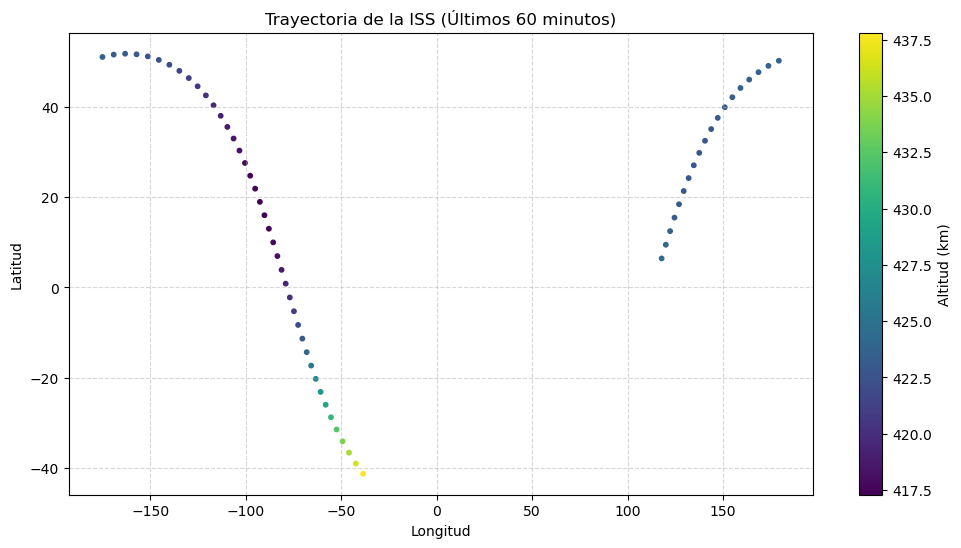

In [6]:
import matplotlib.pyplot as plt

# 1. Configuramos el gráfico
plt.figure(figsize=(12, 6))

# 2. Dibujamos los puntos: Longitud en el eje X, Latitud en el eje Y
plt.scatter(df_iss['longitud'], df_iss['latitud'], c=df_iss['altitud_km'], cmap='viridis', s=10)

# 3. Añadimos detalles al gráfico
plt.colorbar(label='Altitud (km)')
plt.title('Trayectoria de la ISS (Últimos 60 minutos)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True, linestyle='--', alpha=0.5)

# 4. Guardamos la imagen en tu carpeta de resultados
plt.savefig("../results/trayectoria_iss.png")
plt.show()

Para la validación de los datos obtenidos, se ha generado una representación gráfica de la trayectoria utilizando la librería Matplotlib. Esta visualización permite confirmar que la inclinación orbital y el desplazamiento geográfico corresponden con los parámetros operacionales reales de la ISS.
Fuente: Hunter, J. D. (2007). Matplotlib: A 2D graphics environment.